In [1]:
%load_ext autoreload
%autoreload 2

# Import 

In [2]:
from bosonic_jax import Qubit, GKPQubit, execute, BosonicRegister, BosonicCircuit, PhaseRotationGate, \
                    DisplaceGate, NumSplitCDGate, QubitRotationGate, NumDepQubitRotationGate, CDGate
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Create Bosonic Circuit 

In [3]:
# Circuit containing 1 cavity and 1 qubit
breg = BosonicRegister([GKPQubit(),Qubit()])
bcirc = BosonicCircuit(breg)

# set up circuit
bcirc.reset() # initialize each qubit in |+z>
bcirc.x(0) # added to gates list
bcirc.x(1) # added to gates list

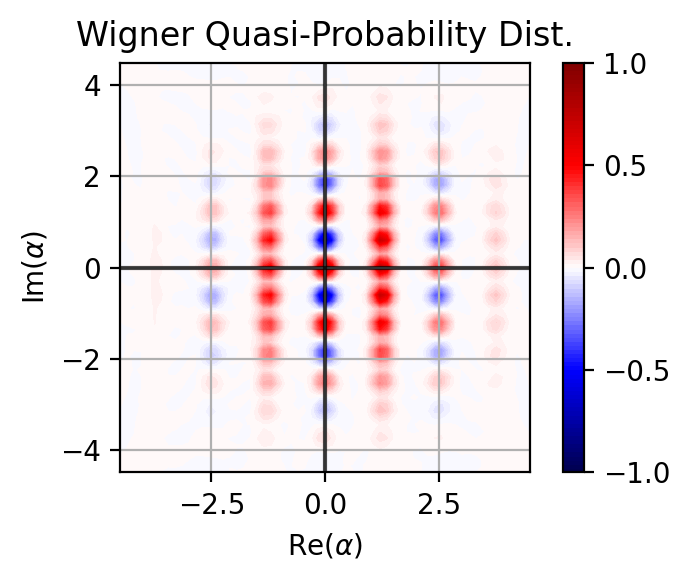

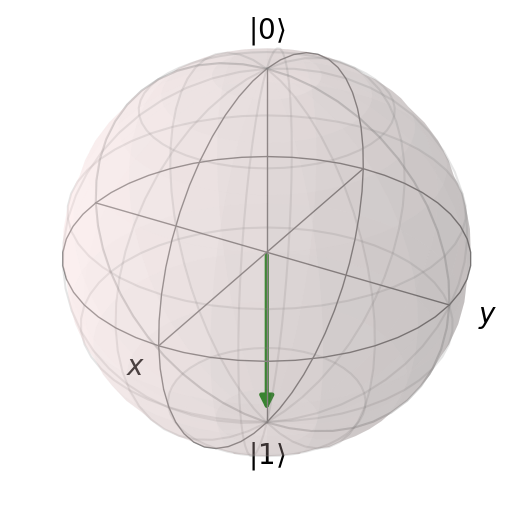

In [4]:
results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"
results.plot(bcirc, 0)
results.plot(bcirc, 1)

# Custom Gates

In [5]:
# set up new circuit
breg = BosonicRegister([GKPQubit(),Qubit()])
bcirc = BosonicCircuit(breg)

bcirc.reset()
# bcirc.x(0)
bcirc.x(1)
bcirc.add(PhaseRotationGate, 0, {"phi": np.pi/4})
# bcirc.add(DisplaceGate, 1, {"alpha": 1})
bcirc.add(CDGate, (0,1), {"beta": 1})

In [6]:
results = execute(bcirc, "unitary_jax") # or "hamiltonian_jax"

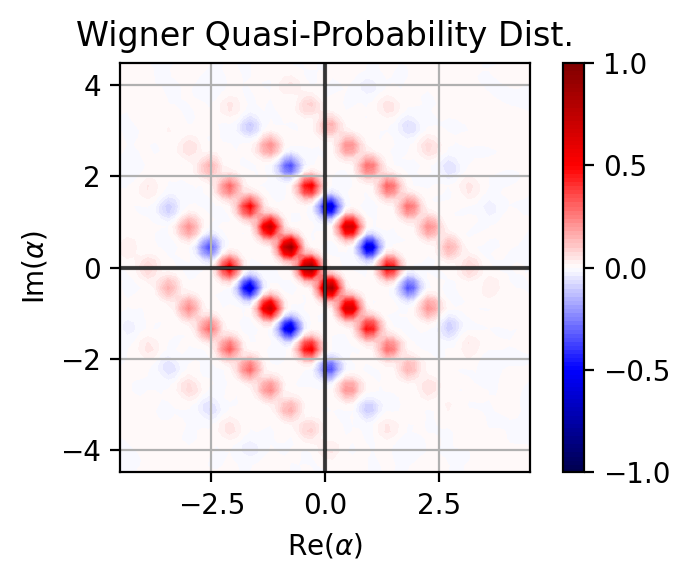

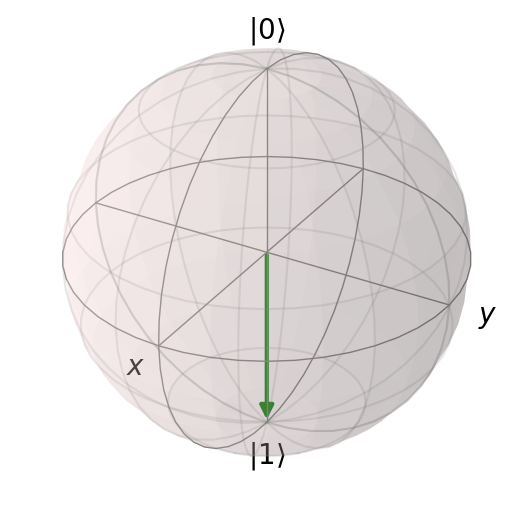

In [7]:
results.plot(bcirc, 0)
results.plot(bcirc, 1)

# Hamiltonian Simulations

## Demo: Number-Split Conditional Displacement

In [8]:
import bosonic_jax.utils.jax_qutip as jqt
from jax import device_put
import jax.numpy as jnp

In [9]:
π = jnp.pi
χ = 2*π * 2
K = 2*π * 0


beta = jnp.sqrt(2)*2*(2.5 + 2j)

N = 50
a = jqt.destroy(N)
a_dag = jqt.dag(a)

I_q = jnp.eye(2)
I_a = jnp.eye(N)
aq = jnp.kron(a, I_q)
aq_dag = jqt.dag(aq)
H0 = jnp.kron(χ*a_dag@a, jqt.sigmaz()) + (K/2)*aq_dag @ aq_dag @ aq @ aq

In [10]:
params={
    "beta": beta,
    "chi": χ
}
ts = jnp.linspace(0.0, 2*π/χ, 251)

# set up new circuit
breg = BosonicRegister([GKPQubit(),Qubit()])
bcirc = BosonicCircuit(breg)
bcirc.add(NumSplitCDGate, (0,1), params, ts)

In [11]:
results = execute(bcirc, "hamiltonian_jax", H0=H0, c_ops=[])

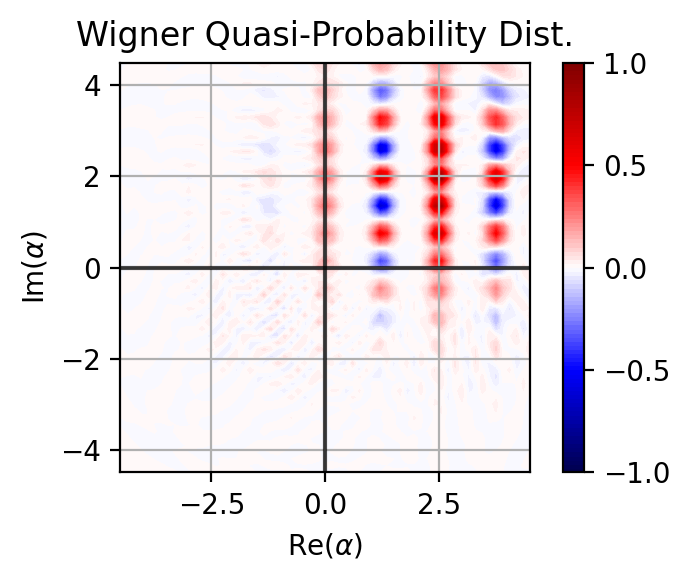

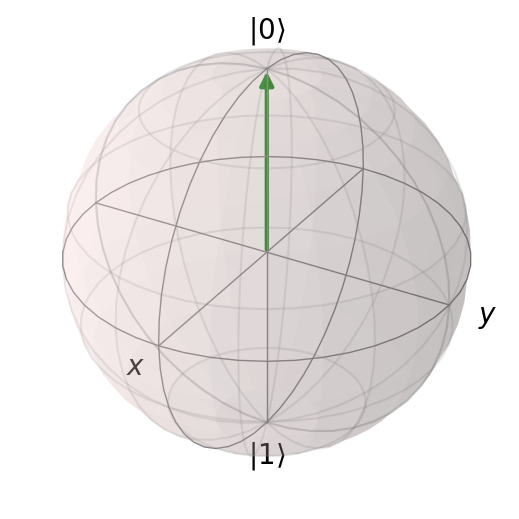

In [12]:
results.plot(bcirc, 0)
results.plot(bcirc, 1)

In [13]:
results.calc_expect(aq, "aq")

In [14]:
def plot_trajectory(ts, expectation):
    fig, axs = plt.subplots(1,2, dpi=200, figsize=(8,4))
    axs[0].plot(np.real(expectation), np.imag(expectation))
    axs[0].set_xlabel(r"$\langle \hat{q}\rangle$")
    axs[0].set_ylabel(r"$\langle \hat{p}\rangle$")
    
    axs[1].plot(ts, np.real(expectation), label=r"$\langle \hat{q}\rangle$")
    axs[1].plot(ts, np.imag(expectation), label=r"$\langle \hat{p}\rangle$")
    axs[1].set_ylabel(r'Expectation of quadratures')
    axs[1].set_xlabel('Time')
    axs[1].legend()

    fig.tight_layout()
    plt.show()

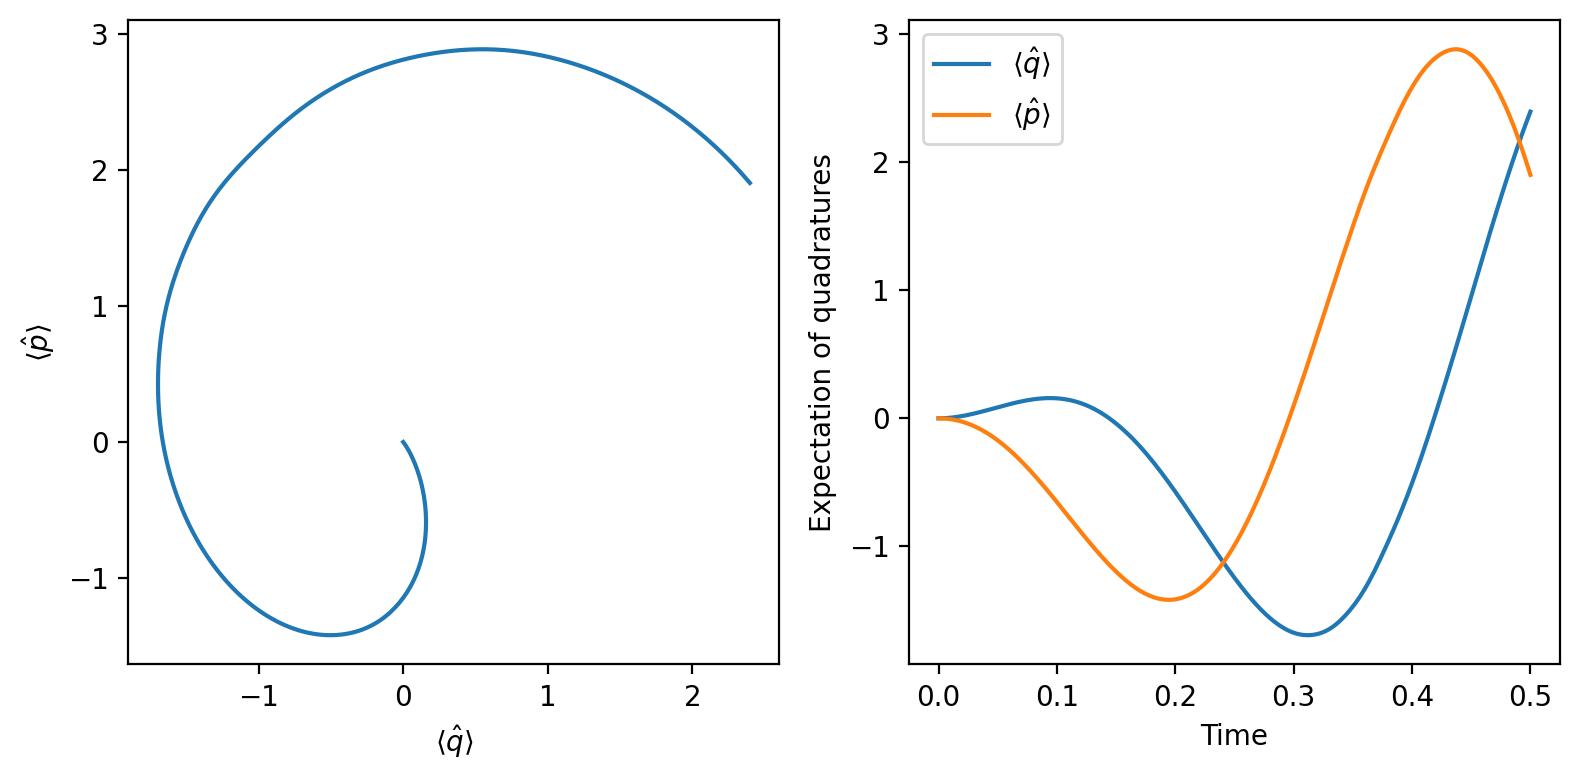

1.9024604558135192


In [15]:
expt = results[0]["aq"]
plot_trajectory(ts, expt)
print(np.imag(expt[-1]))